In [107]:

import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from pymongo import MongoClient
import joblib

In [ ]:
# connect to mongodb
mongo = MongoClient(port=27017)

for dbname in mongo.list_database_names():
    if dbname == "texasSchoolsDB":
        print(f'{dbname} <----------')
    else:
        print(dbname)

In [109]:
# find collections
db = mongo["texasSchoolsDB"]
db.list_collection_names()

['teachers20_21',
 'school_info',
 'scores_finances',
 'schools_2022_to_2023_geojson',
 'demographics',
 'staar20_21',
 'coordinates',
 'scores_coordinates',
 'account_ratings22',
 'tor20_21',
 'satscores20_21',
 'scores_finances_coordinates',
 'current_districts_geojson',
 'staar19_20',
 'DISTRICTS_INFO_2020_21',
 'NN_model',
 'demographic20_21']

# Data Processing

In [110]:
# Grab collections from mongodb and convert it to a pandas dataframe
collection1 = db.DISTRICTS_INFO_2020_21
collection2 = db.staar20_21

all_info = pd.DataFrame(list(collection1.find()))
staar19 = pd.DataFrame(list(collection2.find()))

In [111]:
# Merge previous STAAR data with current District info
completedf = pd.merge(staar19, all_info, on='DISTRICT NAME', how="inner")

In [112]:
# calculate change in STAAR SCORES and add to DB
completedf['Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD'] = completedf['STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_y'] - completedf['STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x']
completedf['Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE'] = completedf['STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y'] - completedf['STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x']
completedf['Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE'] = completedf['STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y'] - completedf['STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x']

In [113]:
completedf.columns.to_list()

['_id_x',
 'DISTRICT NAME',
 'TOTAL NUMBER OF SCHOOLS_x',
 'TOTAL STUDENTS_x',
 'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 '

In [114]:
# Drop the non-beneficial columns 
completedf = completedf.drop(columns=['_id_x',
 'DISTRICT NAME',
 'TOTAL NUMBER OF SCHOOLS_x',
 'TOTAL STUDENTS_x',
 'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % SOCIAL STUDIES AT MASTERS GRADE LEVEL STANDARD_x',
 ' STAAR: % AFRICAN AMERICAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AFRICAN AMERICAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AFRICAN AMERICAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % HISPANIC AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % HISPANIC AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % HISPANIC AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % WHITE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % WHITE AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % WHITE AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ASIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ASIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ASIAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % TWO OR MORE RACES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % TWO OR MORE RACES AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 ' STAAR: % TWO OR MORE RACES AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % AMERICAN INDIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AMERICAN INDIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % AMERICAN INDIAN AT MASTERS GRADE LEVEL STANDARD_x',
 'STAAR: % PACIFIC ISLANDER AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % PACIFIC ISLANDER AT MEETS GRADE LEVEL STANDARD OR ABOVE_x',
 'STAAR: % PACIFIC ISLANDER AT MASTERS GRADE LEVEL STANDARD_x',
 '_id_y',
 'DISTRICT NUMBER',
 'COUNTY NUMBER AND NAME',
 'EDUCATION SERVICE CENTER REGION',
 'TOTAL NUMBER OF SCHOOLS_y',
 'STUDENTS: % AFRICAN AMERICAN',
 'STUDENTS: % HISPANIC',
 'STUDENTS: % WHITE',
 'STUDENTS: % AMERICAN INDIAN',
 'STUDENTS: % ASIAN',
 'STUDENTS: % PACIFIC ISLANDER',
 'STUDENTS: % TWO OR MORE RACES',
 'STUDENTS: % ECONOMICALLY DISADVANTAGED',
 'STUDENTS: % ENGLISH LEARNERS (EL)',
 'STUDENTS: % SPECIAL EDUCATION',
 'STUDENTS: % BILINGUAL/ESL EDUCATION',
 'STUDENTS: % CAREER & TECHNICAL EDUCATION',
 'STUDENTS: % GIFTED & TALENTED EDUCATION',
 'ANNUAL DROPOUT RATE GR',
 '5-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2020) DISTRICT EXCL',
 ' 6-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2019) DISTRICT EXCL',
 'ANNUAL GRADUATE COUNT (2020-21)',
 'ANNUAL RHSP/DAP/FHSP-E/FHSP-DLA GRADUATE COUNT (2020-21)',
 'STAAR: % SCIENCE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SCIENCE AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SCIENCE AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % SOCIAL STUDIES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 ' STAAR: % SOCIAL STUDIES AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % SOCIAL STUDIES AT MASTERS GRADE LEVEL STANDARD_y',
 ' STAAR: % AFRICAN AMERICAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AFRICAN AMERICAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AFRICAN AMERICAN AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % HISPANIC AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % HISPANIC AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % HISPANIC AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % WHITE AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % WHITE AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % WHITE AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % ASIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ASIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ASIAN AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % TWO OR MORE RACES AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % TWO OR MORE RACES AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 ' STAAR: % TWO OR MORE RACES AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ECONOMICALLY DISADVANTAGED AT MASTERS GRADE LEVEL STANDARD_y',
 'SAT-AVERAGE SCORE (2021-2020)',
 'TOTAL STAFF FTE',
 'TOTAL TEACHER FTE',
 'STAFF: % CENTRAL ADMINISTRATIVE',
 'STAFF: % SCHOOL ADMINISTRATIVE',
 'STAFF: % PROFESSIONAL SUPPORT',
 'STAFF: % TEACHERS',
 'STAFF: % EDUCATIONAL AIDES',
 'STAFF: % AUXILIARY',
 'AVERAGE SALARY: CENTRAL ADMINISTRATIVE',
 'AVERAGE SALARY: SCHOOL ADMINISTRATIVE',
 'AVERAGE SALARY: PROFESSIONAL SUPPORT',
 'AVERAGE SALARY: TEACHER',
 'STAFF: % MINORITY',
 'NUMBER OF STUDENTS PER TOTAL STAFF',
 'NUMBER OF STUDENTS PER TEACHER',
 'TEACHER: % WITH 5 OR FEWER YEARS OF EXPERIENCE',
 'TEACHER: AVERAGE YEARS OF EXPERIENCE',
 'TEACHER: % WITH ADVANCED DEGREES',
 'TEACHER: TURNOVER RATE',
 'TEACHER: % AFRICAN AMERICAN',
 'TEACHER: % HISPANIC',
 'TEACHER: % WHITE',
 'TEACHER: % AMERICAN INDIAN',
 'TEACHER: % ASIAN',
 'TEACHER: % PACIFIC ISLANDER',
 'TEACHER: % TWO OR MORE RACES',
 'TEACHER: % REGULAR EDUCATION',
 'TEACHER: % SPECIAL EDUCATION',
 'TEACHER: % COMPENSATORY EDUCATION',
 'TEACHER: % BILINGUAL/ESL EDUCATION',
 'TEACHER: % CAREER & TECHNICAL EDUCATION',
 'TEACHER: % OTHER EDUCATION (INCLUDES G & T)',
 'TAXABLE VALUE PER PUPIL (2019 TAX YEAR)',
 'LOCALLY ADOPTED TAX RATE (2020 TAX YEAR)',
 'TOTAL OPERATING AND OTHER REVENUE (2020-21)',
 'Total OPERATING AND OTHER REVENUE PER PUPIL',
 'Total OPERATING REVENUE (2020-21)',
 'REVENUE: % STATE',
 'REVENUE: % LOCAL AND OTHER',
 'REVENUE: % FEDERAL',
 'TOTAL OTHER REVENUE(2020-21)',
 'FUND BALANCE (FOR ISDS)',
 'NET ASSETS (CHARTER SCHOOLS)',
 'TOTAL ACTUAL EXPENDITURES (2020-21)',
 'TOTAL ACTUAL OPERATING EXPENDITURES (2020-21)',
 'TOTAL ACTUAL OPERATING EXPENDITURES PER PUPIL',
 'EXPENDITURE: % INSTRUCTIONAL',
 'EXPENDITURE: % CENTRAL ADMINISTRATIVE',
 'EXPENDITURE: % SCHOOL LEADERSHIP',
 'EXPENDITURE: % PLANT SERVICES',
 'EXPENDITURE: % OTHER OPERATING',
 'TOTAL ACTUAL INSTRUCTIONAL EXPENDITURES',
 'TOTAL ACTUAL INSTRUCTIONAL EXPENDITURES PER PUPIL',
 ' EXPENDITURE: % BASIC EDUCATION SERVICES',
 'EXPENDITURE: % SPECIAL EDUCATION',
 'EXPENDITURE: % STATE COMPENSATORY EDUCATION',
 'EXPENDITURE: % BILINGUAL/ESL EDUCATION',
 'EXPENDITURE: % CAREER & TECHNICAL EDUCATION',
 ' EXPENDITURE: % GIFTED & TALENTED EDUCATION',
 'EXPENDITURE: % ATHLETICS/RELATED ACTIVITIES',
 'EXPENDITURE: % HIGH SCHOOL ALLOTMENT',
 'EXPENDITURE: % PREKINDERGARTEN',
 'EXPENDITURE: % UN-ALLOCATED',
 'DISTRICT SIZE',
 'COMMUNITY TYPE',
 'PROPERTY WEALTH',
 'TAX RATE',
 'STAAR: % AMERICAN INDIAN AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AMERICAN INDIAN AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % AMERICAN INDIAN AT MASTERS GRADE LEVEL STANDARD_y',
 'ACT-AVERAGE SCORE (2021-2020)',
 'STAAR: % PACIFIC ISLANDER AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % PACIFIC ISLANDER AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % PACIFIC ISLANDER AT MASTERS GRADE LEVEL STANDARD_y',
   'STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD_y',
  'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD',
 'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE',
 'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE',])

In [115]:
completedf

,DISTRICT ACCOUNTABILITY RATINGS,TOTAL STUDENTS_y,ATTENDANCE RATE (2020-21),4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL,STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y,STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y,STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y,COLLEGE ADMISSIONS: % TESTED (2020-2021),COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)
0,A,574,96.7,100.0,81.0,67.0,39.0,88.0,65.0,34.0,58.3,19.0
1,A,1150,96.0,100.0,85.0,64.0,34.0,84.0,49.0,23.0,51.6,27.7
2,A,808,95.4,95.2,84.0,63.0,24.0,85.0,57.0,26.0,92.7,36.8
3,A,342,95.8,95.8,87.0,67.0,30.0,94.0,69.0,27.0,87.0,15.0
4,B,3360,93.7,99.0,72.0,48.0,20.0,75.0,44.0,20.0,43.3,49.4
...,...,...,...,...,...,...,...,...,...,...,...,...
1224,A,212,95.4,100.0,87.0,58.0,29.0,85.0,54.0,28.0,77.8,7.1
1225,A,696,95.6,88.9,83.0,61.0,30.0,81.0,55.0,25.0,93.8,23.3
1226,B,3284,92.1,93.3,59.0,34.0,13.0,59.0,30.0,14.0,74.1,8.3
1227,B,1779,88.8,94.8,60.0,32.0,10.0,53.0,19.0,6.0,15.3,5.9


In [116]:
completedf.columns.to_list()

['DISTRICT ACCOUNTABILITY RATINGS',
 'TOTAL STUDENTS_y',
 'ATTENDANCE RATE (2020-21)',
 '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
 'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)']

In [117]:
# convert columns to Numeric
columns_to_convert = ['TOTAL STUDENTS_y',
 'ATTENDANCE RATE (2020-21)',
 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
 'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)',
  '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL']

completedf[columns_to_convert] = completedf[columns_to_convert].replace({',': '', '%': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

In [118]:
completedf=completedf.dropna()

# Compile, Train, and Evaluate Model

In [119]:
# Remove 'DISTRICT ACCOUNTABILITY RATINGS' target from features data
X = completedf.drop(columns=['DISTRICT ACCOUNTABILITY RATINGS']) 
y = completedf['DISTRICT ACCOUNTABILITY RATINGS']  

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variables
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print(X_train_scaled.shape)

(804, 11)


In [120]:
# Save the scaler to disk
joblib.dump(scaler, 'scaler.gz')

['scaler.gz']

In [121]:
# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=11))
# Add more hidden layers
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='relu'))

# Add the output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print model summary
model.summary()



/Users/amarillinovel/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 80)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,631 (57.15 KB)

 Trainable params: 14,631 (57.15 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# fit training model
model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5541 - loss: 0.8700 - val_accuracy: 0.6335 - val_loss: 0.6162
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7068 - loss: 0.6473 - val_accuracy: 0.6957 - val_loss: 0.5530
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7693 - loss: 0.5495 - val_accuracy: 0.6708 - val_loss: 0.5220
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7429 - loss: 0.6308 - val_accuracy: 0.6770 - val_loss: 0.5151
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7417 - loss: 0.7478 - val_accuracy: 0.6894 - val_loss: 0.5114
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7530 - loss: 0.5865 - val_accuracy: 0.6957 - val_loss: 0.5085
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7711 - loss: 0.5532 - val_accuracy: 0.7019 - val_loss: 0.5072
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.5277 - val_accuracy: 0.7143 - val_loss:

In [123]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test_encoded,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9/9 - 0s - 2ms/step - accuracy: 0.7649 - loss: 0.5631
Loss: 0.5630699396133423, Accuracy: 0.7649253606796265


In [74]:
#save NN

model.save("ISD_Accountability.keras")

# Correlation Matrix

In [124]:

# Convert numeric columns that are read as strings to numeric, handling errors
numeric_columns = [
    'TOTAL STUDENTS_y',
    'ATTENDANCE RATE (2020-21)',
    '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL',
    'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y',
    'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y',
    'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y',
    'COLLEGE ADMISSIONS: % TESTED (2020-2021)',
    'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)'
]
for column in numeric_columns:
    completedf[column] = pd.to_numeric(completedf[column], errors='coerce')


# district accountability ratings might be mapped if they are like grades
ratings_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1}
completedf['DISTRICT ACCOUNTABILITY RATINGS'] = completedf['DISTRICT ACCOUNTABILITY RATINGS'].map(ratings_map)




/var/folders/vf/_j2gkjzn02s0myp33_2rv0gr0000gn/T/ipykernel_26555/3339007593.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completedf[column] = pd.to_numeric(completedf[column], errors='coerce')
/var/folders/vf/_j2gkjzn02s0myp33_2rv0gr0000gn/T/ipykernel_26555/3339007593.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completedf['DISTRICT ACCOUNTABILITY RATINGS'] = completedf['DISTRICT ACCOUNTABILITY RATINGS'].map(ratings_map)


In [125]:
# Calculate the correlation matrix for numeric columns only
correlation_matrix = completedf[numeric_columns].corr()
print(correlation_matrix)



                                                    TOTAL STUDENTS_y  \
TOTAL STUDENTS_y                                            1.000000   
ATTENDANCE RATE (2020-21)                                   0.010370   
4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 202...         -0.054115   
STAAR: % ELA/READING AT APPROACHES GRADE LEVEL ...         -0.048262   
STAAR: % ELA/READING AT MEETS GRADE LEVEL STAND...          0.012346   
STAAR: % ELA/READING AT MASTERS GRADE LEVEL STA...          0.076469   
STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL ...         -0.037725   
STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STAND...          0.022186   
STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STA...          0.068661   
COLLEGE ADMISSIONS: % TESTED (2020-2021)                    0.138930   
COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-...          0.134437   

                                                    ATTENDANCE RATE (2020-21)  \
TOTAL STUDENTS_y                                      

In [126]:
# Get a list of DataFrame columns
print(completedf.columns.tolist())

['DISTRICT ACCOUNTABILITY RATINGS', 'TOTAL STUDENTS_y', 'ATTENDANCE RATE (2020-21)', '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL', 'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y', 'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y', 'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y', 'COLLEGE ADMISSIONS: % TESTED (2020-2021)', 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)']


In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
completedf.rename(columns={
    'DISTRICT ACCOUNTABILITY RATINGS': 'ACCOUNTABILITY RATINGS',
    'TOTAL STUDENTS_y': 'TOTAL STUDENTS',
    'ATTENDANCE RATE (2020-21)': 'ATTENDANCE',
    '4-YR LONGITUDINAL GRADUATION RATE (CLASS OF 2021) DISTRICT EXCL': 'GRADUATION RATE',
    'STAAR: % ELA/READING AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y': '% ELA/READING AT APPROACHES GRADE LEVEL',
    'STAAR: % ELA/READING AT MEETS GRADE LEVEL STANDARD OR ABOVE_y': '% ELA/READING AT MEETS GRADE LEVEL STANDARD',
    'STAAR: % ELA/READING AT MASTERS GRADE LEVEL STANDARD_y': ' % ELA/READING AT MASTERS GRADE LEVEL',
    'STAAR: % MATHEMATICS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE_y': '% MATH AT APPROACHES GRADE LEVEL',
    'STAAR: % MATHEMATICS AT MEETS GRADE LEVEL STANDARD OR ABOVE_y': '% MATH AT MEETS GRADE LEVEL',
    'STAAR: % MATHEMATICS AT MASTERS GRADE LEVEL STANDARD_y': ' % MATHEMATICS AT MASTERS GRADE',
    'COLLEGE ADMISSIONS: % TESTED (2020-2021)': 'COLLEGE ADMISSIONS: % TESTED',
    'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION (2020-2021)': 'COLLEGE ADMISSIONS: % AT/ABOVE CRITERION',
    'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL STANDARD': 'Change in STAAR: % ALL SUBJECTS AT MASTERS GRADE LEVEL',
    'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL STANDARD OR ABOVE': 'Change in STAAR: % ALL SUBJECTS AT MEETS GRADE LEVEL',
    'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL STANDARD OR ABOVE': 'Change in STAAR: % ALL SUBJECTS AT APPROACHES GRADE LEVEL'
}, inplace=True)

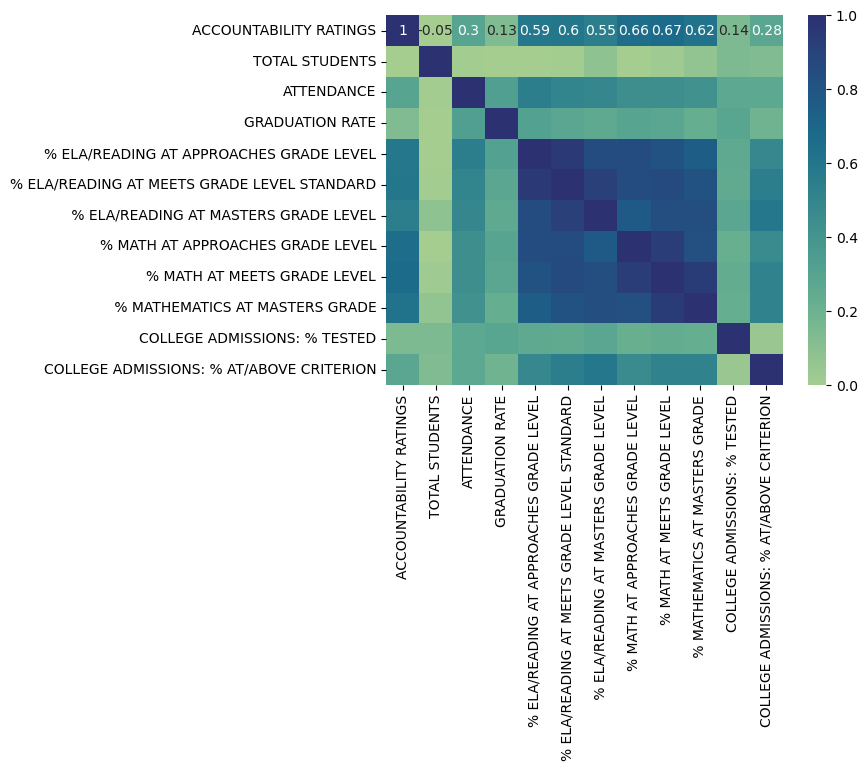

In [129]:
matrix = completedf.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, cmap='crest')
plt.show()

In [85]:
plt.savefig('heatmap.png')

<Figure size 640x480 with 0 Axes>